<a href="https://colab.research.google.com/github/marcelakardec27/python/blob/main/genAI_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

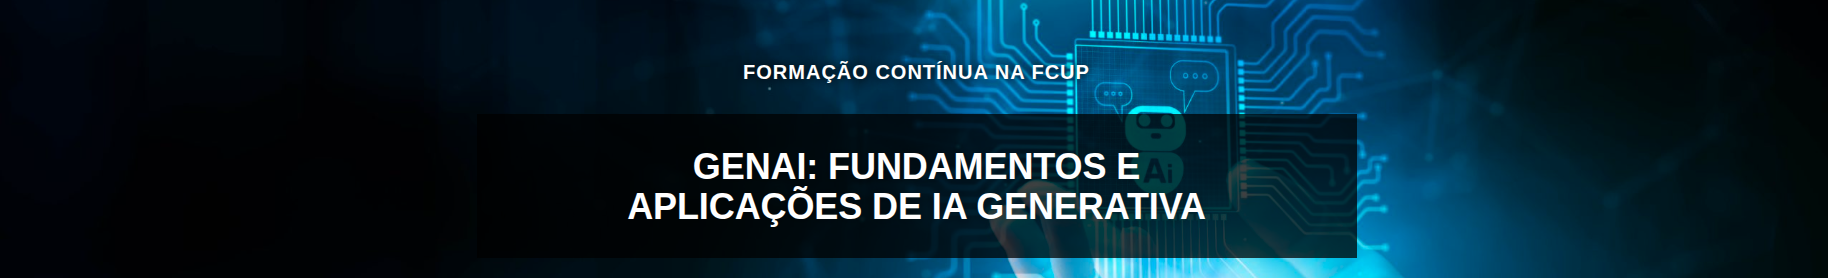


#Prática 3 - Engenharia de Prompts e RAG

Nesta prática vamos explorar diferentes conceitos de engenharia de prompts. No entanto, para tornar a tarefa mais desafiante e alinhada com o contexto empresarial (onde, por vezes, é necessário usar modelos menores e evitar dependência de serviços externos como o ChatGPT, devido a dados sensíveis), vamos trabalhar com o modelo mais recente e compacto da Google: Gemma-3.

#Engenharia de Prompts

##Instalação de requisitos

Para isso, vamos utilizar novamente o Ollama. Começamos por instalar as bibliotecas e o software necessários para configurar o ambiente de execução.

 Nesta aula, vamos no entanto, substituir o colab-xterm, pelo terminal diretamente integrado no Google Colab. Para isso clique no botão terminal na aba inferior da janela Screenshot from 2025-10-24 19-46-05.png. Deverá aparecer uma janela de terminal do lado do direito do ecrã que terá o mesmo efeito que o colab-xterm

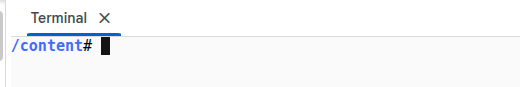

Depois de abrir o terminal no Colab, é necessário introduzir alguns comandos directamente no terminal para instalar o Ollama e disponibilizar o modelo para utilização. Isto acontece porque, no ambiente do Google Colab, não temos o Ollama pré-instalado nem acesso directo a GPUs potentes, pelo que é preciso preparar o ambiente de execução manualmente.

O primeiro comando é:

```
curl https://ollama.ai/install.sh | sh
```

Este comando descarrega e executa o script oficial de instalação do Ollama, que trata de instalar todas as componentes necessárias para correr modelos localmente dentro do Colab. Após este passo, o Ollama fica pronto para ser utilizado através do terminal.

Após este passo temos que executar a instância do ollama. Para isso corremos o comando

Por fim disponibilizamos o servidor de ollama com

```
ollama serve &
```
Isto fará o ollama correr no background do terminal, permitindo a introdução de novos comandos.

Por fim, precisamos de descarregar os modelos que vamos utilizar hoje com os commandos ollama pull. Reutilizamos o gemma3:1b-it-qat (*ollama pull gemma3:1b-it-qat*) assim como usaremos o modelo nomic-embed-text para geração dos embeddings .

```
ollama pull  gemma3:1b-it-qat
```


```
ollama pull  nomic-embed-text
```




Podemos agora verificar se os modelos estão disponíveis para utilização!

In [ ]:
!ollama list

NAME                       ID              SIZE      MODIFIED       
nomic-embed-text:latest    0a109f422b47    274 MB    3 seconds ago     
gemma3:1b-it-qat           b491bd3989c6    1.0 GB    20 seconds ago    


## Instalação e Exemplos LangChain

Para interagir com o modelo vamos utilizar novamente a biblioteca de Python LangChain, um framework concebido para simplificar a integração de modelos de linguagem em aplicações. O LangChain fornece um conjunto de ferramentas que facilita criar, encadear e orquestrar interacções com LLMs (Large Language Models).

Começamos por instalar as bibliotecas necessárias

In [ ]:
%pip install -U langchain-ollama

De seguida importamos a biblioteca para o ambiente Python

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

Entre as funcionalidades mais relevantes do LangChain estão os Prompt Templates, que permitem definir modelos de prompt reutilizáveis com variáveis e parâmetros dinâmicos, ajudando a manter consistência e a experimentar facilmente diferentes abordagens

In [ ]:
# Criar uma instância do modelo Gemma-3 a correr no Ollama
llm = OllamaLLM(model="gemma3:1b-it-qat")


# Definir um Prompt Template com variáveis
template = """
Responde de forma clara e concisa à seguinte questão:
{pergunta}
"""

#Cria a prompt com base no prompt template
prompt = ChatPromptTemplate.from_template(template)

model = OllamaLLM(model="gemma3:1b-it-qat")

#Liga a prompt ao modelo
chain = prompt | model

#gera a reposta passando os argumentos necessários em forma de dicionário. Por exemplo neste caso a nossa prompt template tinha a variável "pergunta" para ser completada
resposta=chain.invoke({"pergunta": "O que é Portugal?"})

In [ ]:
print(resposta)

In [ ]:
# Definir um Prompt Template com variáveis
template = """
Responde de forma clara e concisa à seguinte questão:
{pergunta}
Resposta: Tem que ser escrita em {lingua}
"""

#Cria a prompt com base no prompt template
prompt = ChatPromptTemplate.from_template(template)

#Liga a prompt ao modelo
chain = prompt | model

#Agora o nosso template aceita duas variáveis: pergunta e lingua
resposta=chain.invoke({"pergunta": "O que é Portugal?","lingua":"espanhol"})



In [ ]:
print(resposta)

# Exercícios com prompt templates

## Exercício 1

**1.1**
Crie um prompt template no LangChain para gerar uma carta de motivação personalizada para uma vaga de emprego.
O título ou descrição da vaga deverá ser fornecido pelo utilizador através do comando input() do Python (recorde o exemplo mostrado no notebook de introdução).

De seguida, utilizando o LangChain e o prompt template que construiu, faça com que o modelo gere automaticamente uma carta de motivação adequada à vaga indicada pelo utilizador.

In [ ]:
#resolução

**1.2**
Expanda o exercício anterior para permitir que o utilizador introduza várias vagas de emprego.
Utilize um ciclo for em Python para pedir ao utilizador uma lista de vagas (por exemplo, introduzindo uma vaga de cada vez ou lendo uma lista pré-definida).

Para cada vaga:

preencha o prompt template criado anteriormente;

gere automaticamente uma carta de motivação usando o LangChain;

guarde cada carta num ficheiro .txt (um ficheiro por vaga), com um nome identificativo da vaga.

In [ ]:
#resolução

**1.3**

Altere o exercício anterior para que o utilizador possa também indicar o tom e o estilo das cartas de motivação a gerar. Por exemplo, o utilizador poderá pedir um estilo mais formal e um tom mais assertivo.

Para isso:

peça ao utilizador, através de input(), que introduza o tom e o estilo desejados;

modifique o prompt template criado anteriormente para incluir estes dois factores adicionais;

gere as cartas de motivação considerando não só a vaga, mas também o tom e o estilo escolhidos.

In [ ]:
#resolução

#RAG

## O que vamos usar


Vamos agora criar uma aplicação RAG (Retrieval-Augmented Generation). Este tipo de aplicação combina a recuperação de informação com a geração de texto, permitindo que um modelo de linguagem (como o Gemma3) produza respostas mais precisas e fundamentadas em dados externos. Para isso, vamos construir três componentes principais.

O primeiro é a base de dados vetorial (vector database), onde iremos armazenar a informação em formato vetorial. Este formato permite que os dados sejam procurados de forma semântica, isto é, com base no significado do texto e não apenas em palavras-chave.

O segundo componente é o mecanismo de recuperação (retriever), responsável por procurar dentro da base vetorial os vetores mais semelhantes à consulta feita pelo utilizador. Estes vetores correspondem aos documentos ou trechos de texto mais relevantes para a pergunta.

Por fim, o terceiro componente é o modelo generativo. Este modelo utiliza a informação recuperada pelo retriever para gerar respostas completas, contextualizadas e suportadas por dados reais, em vez de depender apenas do conhecimento interno do modelo.

Neste exemplo, vamos utilizar dados da Internet para simplificar o processo e focar na parte técnica da implementação. No entanto, poderíamos utilizar qualquer outro tipo de documento, como textos biográficos, regulamentos internos, políticas empresariais ou manuais técnicos, dependendo do objetivo da aplicação.

Vamos reaproveitar o LangChain, uma vez que esta biblioteca oferece uma integração com pipelines de RAG e fornece ferramentas prontas para lidar com cada etapa do processo (desde a recuperação de informação até à geração de respostas.

Vamos também utilizar o [Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma/) para armazenar e pesquisar os nossos vetores. O Chroma  é uma base de dados vetorial simples e eficiente que nos permitirá guardar os embeddings e recuperar contexto de forma rápida e semântica.

Por fim, vamos usar o OllamaEmbeddings para converter o texto em vetores numéricos (embeddings). Estes vetores representam o significado das frases e serão a base para que o nosso sistema RAG consiga encontrar e utilizar a informação mais relevante.

Como já foi mencionado, para efeitos de demonstração, vamos utilizar dados provenientes da Internet. Para isso, iremos recorrer à biblioteca BeautifulSoup, que nos permite extrair e converter o conteúdo estruturado de páginas HTML em texto puro. Este processo é fundamental para garantir que a informação armazenada na nossa base de dados vetorial esteja limpa e consistente.

Nota: Existem diversas formas de realizar a limpeza e pré-processamento de texto, e quanto mais eficiente for esta etapa, melhores serão os resultados obtidos pelo modelo na fase de recuperação e geração.

Finalmente, iremos utilizar o Gradio, uma biblioteca em Python que permite criar interfaces gráficas interativas de forma rápida e intuitiva, sem necessidade de conhecimentos avançados de front-end ou desenvolvimento web.

No nosso caso, vamos usar o Gradio para construir uma interface de chatbot, que permitirá interagir com o nosso sistema RAG de forma visual e amigável.

In [ ]:
#já deverá estar de cima mas podemos sempre correr outra vez
!pip install langchain
#!pip install langchain-core
# as outras parte necessárias do langchain
!pip install langchain-community

!pip install chromadb
!pip install gradio

In [ ]:
!pip install ollama

A seguir importamos as bibliotecas necessárias

In [ ]:
import gradio as gr                       # Para a interface web
import ollama
from langchain.text_splitter import RecursiveCharacterTextSplitter  # Divide textos longos em blocos menores (útil para o armazenamento de dados)
from langchain_community.document_loaders import WebBaseLoader      # Carrega conteúdo diretamente de páginas web
from langchain_community.vectorstores import Chroma                 # Base de dados vetorial para armazenar embeddings
from langchain_community.embeddings import OllamaEmbeddings         # Gera embeddings a partir de texto usando o Ollama

Próximo passo é definir as fontes que queremos usar (isto é, os websites onde vamos procurar informação). O WebBaseLoader faz o download do HTML e converte-o num formato estruturado que o LangChain pode utilizar como documento. Este será o ponto de partida para gerar os embeddings e construir a nossa base de dados vetorial.

In [ ]:

url = 'https://en.wikipedia.org/wiki/Os_Lus%C3%ADadas' #mais completo
#url ='https://www.culturagenial.com/os-lusiadas-de-camoes/' # mais simples
loader = WebBaseLoader(url)
docs = loader.load()

Depois de carregar o conteúdo da página, é importante dividir o texto em partes menores para facilitar o processamento e a criação dos embeddings.

Utilizamos o RecursiveCharacterTextSplitter do LangChain, que separa o texto em blocos de até 1000 caracteres, com uma sobreposição de 200 caracteres entre eles.
Esta sobreposição ajuda o modelo a preservar o contexto entre os blocos, evitando perda de informação importante nas transições do texto.

In [ ]:

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)


Usamos o OllamaEmbeddings para converter os blocos de texto em vetores numéricos (embeddings). De seguida, o Chroma armazena esses vetores numa base de dados vetorial, permitindo recuperar rapidamente o conteúdo mais relevante durante as consultas.


In [ ]:
# Cria os embeddings usando o Ollama embeddings (com o modelo nomic-embed-text) e guarda numa vector store
# Pode demorar um pouco dependendo do tamanho do ficheiro (neste ambiente pode demorar alguns minutos (mais de 5)
#por causa do tamanho da página)
embeddings = OllamaEmbeddings(model="nomic-embed-text")
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

Nesta etapa, definimos a função ollama_llm, responsável por enviar uma pergunta e o respetivo contexto para o modelo de linguagem Gemma3, executado localmente através do Ollama.

A função começa por criar um prompt template que vai combinar a pergunta do utilizador com o contexto recuperado da base vetorial. Em seguida, faz a chamada ao modelo utilizando ollama.chat(), que retorna a resposta gerada.

In [ ]:
def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(model="gemma3:1b-it-qat", messages=[{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']

Aqui criamos o retriever a partir da base de dados vetorial Chroma, responsável por encontrar os textos mais relevantes em relação à pergunta do utilizador. Quando uma consulta é feita, o retriever converte a pergunta em embeddings e compara-os com os vetores armazenados, medindo a similaridade semântica para identificar os blocos de texto mais próximos no significado.

O método as_retriever() pode receber argumentos como search_type="similarity"  ou search_type="mmr" e search_kwargs={"fetch_k": 3} para definir quantos resultados o retriever deve retornar (por defeito 20). Estes parâmetros permitem equilibrar precisão e diversidade na recuperação de contexto antes do envio para o modelo LLM. Mais informações na [documentação](https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.base.VectorStore.html#langchain_core.vectorstores.base.VectorStore.as_retriever)

In [ ]:
retriever = vectorstore.as_retriever()

A função rag_chain representa o fluxo completo do sistema RAG. Quando o utilizador faz uma pergunta, esta é primeiro enviada ao retriever, que procura na base vetorial os documentos mais relevantes e os devolve sob a forma de uma lista de trechos de texto. Em seguida, esses textos são concatenados num único contexto formatado, utilizando "\n\n".join(...) para manter a legibilidade.

Esse contexto é então passado, juntamente com a pergunta original, para a função ollama_llm, que chama o modelo de linguagem para gerar uma resposta final.

In [ ]:
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = "\n\n".join(doc.page_content for doc in retrieved_docs)
    answer=ollama_llm(question, formatted_context)
    return answer

Vamos testar se está tudo ok!

In [ ]:
rag_chain("Quais são os primeiros versos dos Lusíadas?")

'Os primeiros versos dos Lusíadas são:\n\n“As armas e os Barões assinalados\nQue da Ocidental praia Lusitana\nPor mares nunca de antes navegados\nPassaram ainda além da Taprobana,\nEm perigos e guerras esforçados\nMais do que prometia a força humana,\nE também as memórias gloriosas\nDaqueles Reis que foram dilatando\nA Fé, o Império, e as terras viciosas\nDe África e de Ásia andaram devastando,\nE aqueles que por obras valerosas\nSe vão da lei da Morte libertando,\nCantando espalharei por toda parte,\nSe a tanto me ajudar o engenho e arte.”\n\nComentário: Estes versos são um marco importante na narrativa, pois estabelecem a magnitude das conquistas portuguesas e a grandiosidade do poema. Eles descrevem a passagem de Vasco da Gama para a Índia e a riqueza que a empresa trouxe para o reino português.'

Finalmente criamos a  interface da nossa aplicação!

Primeiro, definimos uma função simples (get_important_facts), que serve como ponto de ligação entre o Gradio e o nosso sistema RAG. Sempre que o utilizador introduz uma pergunta, essa função chama a rag_chain, executando todo o fluxo de prcura de infomração na base de dados e geração de resposta usando o Gemma3.

Em seguida, criamos a interface com gr.Interface(), especificando a função que será executada (fn), o campo de entrada (Textbox), e o tipo de saída (text). Também definimos um título e uma descrição para tornar a aplicação mais intuitiva. Por fim, iface.launch() inicia a aplicação web, permitindo interagir diretamente com o chatbot de forma simples e visual.

In [ ]:
# Define the Gradio interface
def get_important_facts(question):
    return rag_chain(question)

# Create a Gradio app interface
iface = gr.Interface(
  fn=get_important_facts,
  inputs=gr.Textbox(lines=2, placeholder="Enter your question here..."),
  outputs=gr.Textbox(lines=4),
  title="RAG com Gemma3",
  description="Faça perguntas do conteudo armazenado!",
)

# Launch the Gradio app
iface.launch()


**Exercício**: Agora que já percebeu como funciona uma RAG, tente criar a sua RAG pessoal e fazer questões com base nessa informação. Por exempo, tente passar um site de um domínio especifico ou um documento (tipo CV) para a RAG e faça perguntas sobre o mesmo. Pode ainda tornar a RAG mais personalizavel ao variar o prompt template ou outra componentes discutidas na aula teórica. Consulte o seguinte [link](https://python.langchain.com/docs/integrations/document_loaders/) para ver como carregar ficheiros de diferentes tipos para a base de dados vetorial.